# Recommender Systems 2022/23

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "Data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path + "decompressed/")

URM_file = open(URM_path, 'r')

In [2]:
import pandas as pd
URM_path = "./Data_manager/challenge/data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [3]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


### BUILD the SPARSE URM matrix

In [4]:
import scipy.sparse as sps
import numpy as np

mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,1
9,0,9,1


In [5]:
n_users = len(URM_all_dataframe["UserID"].unique())
n_items = len(URM_all_dataframe["ItemID"].unique())

URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Let's take a look at the URM


In [6]:
URM_all = sps.csr_matrix(URM_all)
items_per_user = np.ediff1d(URM_all.indptr)

URM_all = sps.csc_matrix(URM_all)
users_per_item = np.ediff1d(URM_all.indptr)

URM_all = sps.csr_matrix(URM_all)

In [7]:
print(items_per_user.shape)
print(users_per_item.shape)

(12638,)
(22222,)


In [8]:
items_per_user = np.sort(items_per_user)
users_per_item = np.sort(users_per_item)

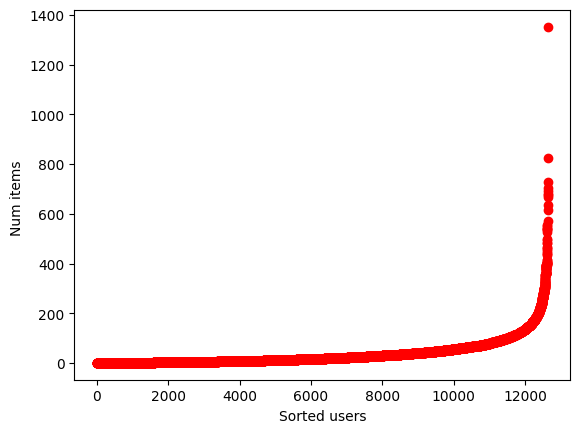

In [9]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(items_per_user, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted users')
pyplot.show()

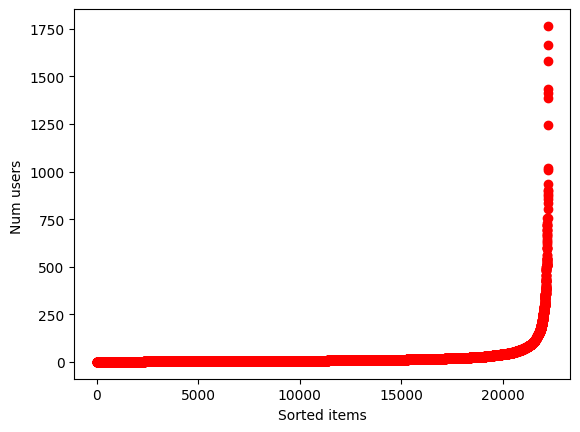

In [10]:
pyplot.plot(users_per_item, 'ro')
pyplot.ylabel('Num users ')
pyplot.xlabel('Sorted items')
pyplot.show()

## DATASET SPLIT

In [11]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2608 (20.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2208 (17.5%) Users that have less than 1 test interactions


## Similarity matrix

In [12]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 22222 (100.0%), 1509.51 column/sec. Elapsed time 14.72 sec


<22222x22222 sparse matrix of type '<class 'numpy.float32'>'
	with 2104633 stored elements in Compressed Sparse Row format>

### predition for a certain user

In [13]:
user_id = 80

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

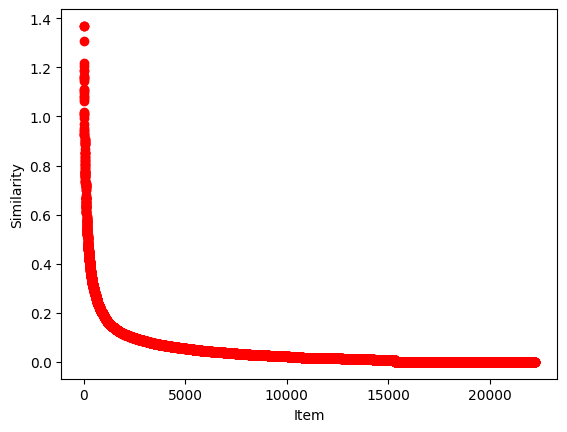

array([ 189,   44,  517,  453,  288,  808,  881, 1266, 3114, 2436])

In [14]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()
ranking[0:10]

### All together inside a class

In [117]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender

# from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
# import numpy as np

# class ItemKNNCFRecommender(object):
    
#     def __init__(self, URM):
#         self.URM = URM

#     def get_URM_train(self):
#         return self.URM
            
#     def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        
#         similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
#                                                   topK=topK, normalize=normalize, 
#                                                   similarity = similarity)
        
#         self.W_sparse = similarity_object.compute_similarity()

        
#     def recommend(self, user_id, at=None, exclude_seen=True):
#         # compute the scores using the dot product
#         user_profile = self.URM[user_id]
#         scores = user_profile.dot(self.W_sparse).toarray().ravel()

#         if exclude_seen:
#             scores = self.filter_seen(user_id, scores)

#         # rank items
#         ranking = scores.argsort()[::-1]
            
#         return ranking[:at]

#     def recommend_user_profile(self, user_profile, at=None, exclude_seen=True):
#         # compute the scores using the dot product
#         scores = user_profile.dot(self.W_sparse).toarray().ravel()

#         if exclude_seen:
#             scores = self.filter_seen(user_id, scores)

#         # rank items
#         ranking = scores.argsort()[::-1]
            
#         return ranking[:at]
    
#     def filter_seen(self, user_id, scores):

#         start_pos = self.URM.indptr[user_id]
#         end_pos = self.URM.indptr[user_id+1]

#         user_profile = self.URM.indices[start_pos:end_pos]
        
#         scores[user_profile] = -np.inf

#         return scores


# class TopPopRecommender(object):

#     def fit(self, URM_train):
        
#         self.URM_train = URM_train

#         item_popularity = np.ediff1d(URM_train.tocsc().indptr)

#         # We are not interested in sorting the popularity value,
#         # but to order the items according to it
#         self.popular_items = np.argsort(item_popularity)
#         self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
#     def recommend(self, user_id, at=5, remove_seen=True):

#         if remove_seen:
#             seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
#             unseen_items_mask = np.in1d(self.popular_items, seen_items, assume_unique=True, invert = True)

#             unseen_items = self.popular_items[unseen_items_mask]

#             recommended_items = unseen_items[0:at]

#         else:
#             recommended_items = self.popular_items[0:at]
            

#         return recommended_items


In [122]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=50.0, topK=10)

top_recommender = TopPop(URM_train)
top_recommender.fit()

ItemKNNCFRecommender: URM Detected 437 ( 3.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 339 ( 1.5%) items with no interactions.
Similarity column 22222 (100.0%), 7944.40 column/sec. Elapsed time 2.80 sec
TopPopRecommender: URM Detected 437 ( 3.5%) users with no interactions.
TopPopRecommender: URM Detected 339 ( 1.5%) items with no interactions.


In [123]:
evaluator_test.evaluateRecommender(top_recommender)

EvaluatorHoldout: Processed 10430 (100.0%) in 5.30 sec. Users per second: 1967


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.028504                 0.052463  0.044719  0.011092    0.019655   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.088957  0.043229  0.034816  0.231544      0.099248  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.825289           0.19109    0.825289       0.000536   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            3.600738                   0.913061             0.001559   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

## Hyperarameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Optimize the recommendation qualtiy on the validation data, then use those hyperparameters to train the model in all the data you have (train + validation) and evaluate on the test data

ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
Similarity column 22222 (100.0%), 8033.99 column/sec. Elapsed time 2.77 sec
EvaluatorHoldout: Processed 10008 (100.0%) in 4.66 sec. Users per second: 2148
ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
Similarity column 22222 (100.0%), 7950.25 column/sec. Elapsed time 2.80 sec
EvaluatorHoldout: Processed 10008 (100.0%) in 4.89 sec. Users per second: 2045
ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
Similarity column 22222 (100.0%), 7885.28 column/sec. Elapsed time 2.82 sec
EvaluatorHoldout: Processed 10008 (100.0%) in 5.18 sec. Users per second: 1934
ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFR

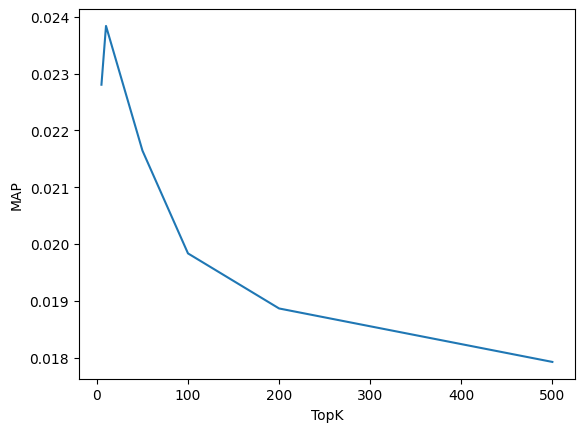

In [18]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

x_tick = [5, 10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_df.loc[10]["MAP"])

pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
Similarity column 22222 (100.0%), 8110.20 column/sec. Elapsed time 2.74 sec
EvaluatorHoldout: Processed 10008 (100.0%) in 5.42 sec. Users per second: 1848
ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
Similarity column 22222 (100.0%), 8039.09 column/sec. Elapsed time 2.76 sec
EvaluatorHoldout: Processed 10008 (100.0%) in 5.58 sec. Users per second: 1795
ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 353 ( 1.6%) items with no interactions.
Similarity column 22222 (100.0%), 8686.59 column/sec. Elapsed time 2.56 sec
EvaluatorHoldout: Processed 10008 (100.0%) in 6.71 sec. Users per second: 1492
ItemKNNCFRecommender: URM Detected 475 ( 3.8%) users with no interactions.
ItemKNNCFR

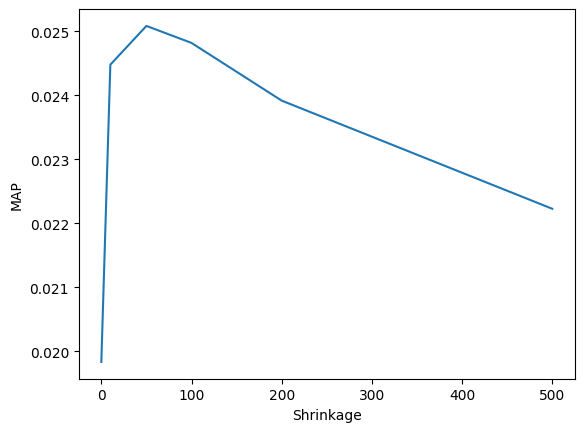

In [20]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

# Generate submissions

In [ ]:
# RETRAIN WITH FULL DATASET
recommender = ItemKNNCFRecommender(URM_all)
recommender.fit(shrink=50.0, topK=10)

top_recommender = TopPopRecommender()
top_recommender.fit(URM_all)

In [18]:
import pandas as pd
URM_path = "./Data_manager/challenge/data_target_users_test.csv"
URM_all_submission_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int},
                                engine='python')

URM_all_submission_dataframe.columns = ["UserID"]

In [55]:
URM_all_submission_dataframe["UserIDMapped"] = URM_all_submission_dataframe["UserID"].map(user_original_ID_to_index)

In [101]:
import pandas as pd
# Assuming you have a DataFrame URM_all_submission_dataframe with 'UserIDMapped' and 'item_list' columns

# First, create a mask for non-null 'UserIDMapped' values
mask = ~URM_all_submission_dataframe['UserIDMapped'].isna()

# Use the mask to make recommendations for non-null 'UserIDMapped'
URM_all_submission_dataframe.loc[mask, 'item_list'] = URM_all_submission_dataframe.loc[mask, 'UserIDMapped'].apply(lambda x: recommender.recommend(int(x), at=10))


In [102]:
item_index_to_original_id = item_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)
URM_all_submission_dataframe['item_list'] = URM_all_submission_dataframe['item_list'].apply(lambda item_indices: [item_index_to_original_id[index] for index in item_indices])

In [103]:
submission = URM_all_submission_dataframe[["UserID","item_list"]]
submission.columns = ["user_id", "item_list"]
submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets

# Convert item_list to string format
submission['item_list'] = submission['item_list'].astype(str)

# Save to CSV without quotes and with the desired format
# submission.to_csv("submission.csv", index=False, header=["user_id", "item_list"], quoting=csv.QUOTE_NONE, sep=',')
def write_csv_without_quotes(df, file_path):
    with open(file_path, 'w', newline='') as f:
        f.write("user_id,item_list\n")
        for index, row in df.iterrows():
            f.write(f"{row['user_id']},{row['item_list']}\n")

# Save the DataFrame to CSV without quotes and with the desired format
write_csv_without_quotes(submission, "submission.csv")

/tmp/ipykernel_12325/1077685429.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].apply(lambda x: ' '.join(map(str, x))) # remove brakets
/tmp/ipykernel_12325/1077685429.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['item_list'] = submission['item_list'].astype(str)


In [104]:
submission['item_list']

0                    101 15 694 869 773 52 1481 36 506 403
1                           11 17 50 28 47 37 136 54 3 145
2                 59 584 259 414 536 956 1097 1001 648 999
3                       27 28 17 11 50 145 314 254 139 171
4                       238 1570 8 278 24 77 243 12 148 66
                               ...                        
10877             36 161 403 6748 506 354 7055 627 34 7394
10878               437 736 265 13 139 644 314 133 593 579
10879    1446 1668 1316 1411 1674 809 1561 6025 11056 1...
10880              1146 639 208 96 1273 138 344 32 324 928
10881        2366 2120 1239 606 6215 325 2237 1069 474 733
Name: item_list, Length: 10882, dtype: object

### When we create the matrices we need to make sure they have the same shape. As we have seen some items and users only appear in one of the two matrices and are missing in the other (if they have no tags or no interactions)

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

#### On this dataset the number of neighbors has a small absolute impact on MAP but a large relative one. Fine-tuning around the best values is needed.

#### Different datasets will behave in different ways.

### Shrinkage

In [ ]:
x_tick_grid = [0, 10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
MAP_per_shrinkage_grid = []

for shrink in x_tick_grid:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage_grid.append(result_df.loc[10]["MAP"])

In [ ]:
x_tick_rnd = loguniform.rvs(0.1, 500, size=12).astype(int)
x_tick_rnd.sort()
x_tick_rnd = list(x_tick_rnd)

MAP_per_shrinkage_rnd = []

for shrink in x_tick_rnd:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_df, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage_rnd.append(result_df.loc[10]["MAP"])

In [ ]:
pyplot.plot(x_tick_grid, MAP_per_shrinkage_grid, label="Grid")
pyplot.plot(x_tick_rnd, MAP_per_shrinkage_rnd, label="Rnd")
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.legend()
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a hyperparameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [ ]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(sps.csc_matrix(ICM_all).indptr)

IDF = np.log(num_tot_items / items_per_feature)

print(ICM_all.shape)
print(IDF.shape)

In [ ]:
np.sort(items_per_feature)

In [ ]:
np.sort(IDF)

In [ ]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [ ]:
feature_index_to_original_ID_dict = {value:key for key,value in feature_original_ID_to_index.iteritems()}

In [ ]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]

for feature_index in highest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])

#### Lowest ranked features

In [ ]:
lowest_ranked_features = sorted_features[-20:]

for feature_index in lowest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])    

In [ ]:
from scipy.sparse import diags
diags(IDF)

In [ ]:
ICM_idf = ICM_all.copy()

ICM_idf = ICM_idf*diags(IDF)

In [ ]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_df.loc[10]

#### Try other feature weighting methods like BM25...

# BM25

In [ ]:
from Recommenders.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [ ]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_df, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_df.loc[10]

#### A small gain over TF-IDF

# Unnormalized similarity matrix

In [ ]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_df, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_df.loc[10]